In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [4]:
# ========================================
# COMPLETE FIXED TRAINING CODE FOR ASL
# ========================================

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
import matplotlib.pyplot as plt
import os


2025-10-14 18:59:03.064066: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1760468343.254227      37 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1760468343.305449      37 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [5]:
# Set paths
train_dir = '/kaggle/input/asl-alphabet/asl_alphabet_train/asl_alphabet_train'
test_dir = '/kaggle/input/asl-alphabet/asl_alphabet_test/asl_alphabet_test'


In [7]:
# Check classes
classes = os.listdir(train_dir)
print("Number of classes:", len(classes))
print("Classes:", classes)


Number of classes: 29
Classes: ['N', 'R', 'space', 'B', 'I', 'del', 'F', 'H', 'E', 'U', 'M', 'X', 'K', 'Q', 'Y', 'S', 'G', 'A', 'O', 'T', 'V', 'Z', 'C', 'P', 'L', 'W', 'D', 'nothing', 'J']


In [8]:
# ========================================
# DATA GENERATORS (FIXED)
# ========================================

# Training data generator - WITH augmentation 
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,          
    width_shift_range=0.15,    
    height_shift_range=0.15,    
    shear_range=0.1,           
    zoom_range=0.15,           
    brightness_range=[0.8, 1.2],
    fill_mode='nearest',
    validation_split=0.1
)

# Validation data generator
val_datagen = ImageDataGenerator(
    rescale=1./255,  
    validation_split=0.1
)

# Create generators
train_gen = train_datagen.flow_from_directory(
    train_dir,
    target_size=(128, 128),
    batch_size=64,
    class_mode='categorical',
    subset='training'
)

val_gen = val_datagen.flow_from_directory(
    train_dir,
    target_size=(128, 128),
    batch_size=64,
    class_mode='categorical',
    subset='validation'
)

print(f"Training samples: {train_gen.n}")
print(f"Validation samples: {val_gen.n}")


Found 78300 images belonging to 29 classes.
Found 8700 images belonging to 29 classes.
Training samples: 78300
Validation samples: 8700


## Phase 1

In [9]:
# ========================================
# MODEL ARCHITECTURE
# ========================================

# Load base model
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(128, 128, 3))
base_model.trainable = False 

# Add custom layers
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)  
predictions = Dense(train_gen.num_classes, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

# Compile model
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# ========================================
# CALLBACKS
# ========================================

callbacks = [
    EarlyStopping(
        monitor='val_loss', 
        patience=5, 
        restore_best_weights=True,
        verbose=1
    ),
    ModelCheckpoint(
        "asl_mobilenetv2_best.h5", 
        save_best_only=True,
        monitor='val_accuracy',
        verbose=1
    ),
    ReduceLROnPlateau(
        monitor='val_loss', 
        factor=0.3, 
        patience=3, 
        verbose=1,
        min_lr=1e-7
    )
]




I0000 00:00:1760468427.778702      37 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [10]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 64, 64,    │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 64, 64,    │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 64, 64,    │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 64, 64,    │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 64, 64,    │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 64, 64,    │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 64, 64,    │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 64, 64,    │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 64, 64,    │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 64, 64,    │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 64, 64,    │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 65, 65,    │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 32, 32,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 32, 32,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 32, 32,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 32, 32,    │      2,304 │ block_1_depthwis

 Total params: 2,593,373 (9.89 MB)

 Trainable params: 335,389 (1.28 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [33]:
# ========================================
# PHASE 1: TRAIN WITH FROZEN BASE
# ========================================

print("\n" + "="*50)
print("PHASE 1: Training with frozen base model")
print("="*50 + "\n")

history = model.fit(
    train_gen,
    epochs=20,
    validation_data=val_gen,
    callbacks=callbacks
)


PHASE 1: Training with frozen base model



/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
1224/1224 ━━━━━━━━━━━━━━━━━━━━ 0s 954ms/step - accuracy: 0.5866 - loss: 1.4084
Epoch 1: val_accuracy improved from -inf to 0.83655, saving model to asl_mobilenetv2_best.h5
1224/1224 ━━━━━━━━━━━━━━━━━━━━ 1265s 1s/step - accuracy: 0.5867 - loss: 1.4080 - val_accuracy: 0.8366 - val_loss: 0.4657 - learning_rate: 0.0010
Epoch 2/20
1224/1224 ━━━━━━━━━━━━━━━━━━━━ 0s 397ms/step - accuracy: 0.8388 - loss: 0.5014
Epoch 2: val_accuracy improved from 0.83655 to 0.85241, saving model to asl_mobilenetv2_best.h5
1224/1224 ━━━━━━━━━━━━━━━━━━━━ 508s 415ms/step - accuracy: 0.8388 - loss: 0.5014 - val_accuracy: 0.8524 - val_loss: 0.4280 - learning_rate: 0.0010
Epoch 3/20
1224/1224 ━━━━━━━━━━━━━━━━━━━━ 0s 380ms/step - accuracy: 0.8626 - loss: 0.4181
Epoch 3: val_accuracy improved from 0.85241 to 0.86736, saving model to asl_mobilenetv2_best.h5
1224/1224 ━━━━━━━━━━━━━━━━━━━━ 486s 397ms/step - accuracy: 0.8626 - loss: 0.4180 - val_accuracy: 0.8674 - val_loss: 0.3749 - learning_rate: 0.0010
Epoch 

In [34]:
# Save model after phase 1
model.save("asl_model_phase1.h5")
print("\n✅ Phase 1 model saved as 'asl_model_phase1.h5'")


✅ Phase 1 model saved as 'asl_model_phase1.h5'


## Phase 2

In [11]:
# ========================================
# PHASE 2: FINE-TUNING (OPTIONAL BUT RECOMMENDED)
# ========================================

print("\n" + "="*50)
print("PHASE 2: Fine-tuning the model")
print("="*50 + "\n")

# Unfreeze the base model
base_model.trainable = True

# Freeze early layers, only train last 30 layers
for layer in base_model.layers[:-30]:
    layer.trainable = False

# Recompile with lower learning rate
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),  # 10x lower
    loss='categorical_crossentropy',
    metrics=['accuracy']
)





PHASE 2: Fine-tuning the model



In [13]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 64, 64,    │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 64, 64,    │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 64, 64,    │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 64, 64,    │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 64, 64,    │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 64, 64,    │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 64, 64,    │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 64, 64,    │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 64, 64,    │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 64, 64,    │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 64, 64,    │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 65, 65,    │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 32, 32,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 32, 32,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 32, 32,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 32, 32,    │      2,304 │ block_1_depthwis

 Total params: 2,593,373 (9.89 MB)

 Trainable params: 1,861,789 (7.10 MB)

 Non-trainable params: 731,584 (2.79 MB)

In [36]:
# Train again
history_fine = model.fit(
    train_gen,
    epochs=10,
    validation_data=val_gen,
    callbacks=callbacks
)

Epoch 1/10


E0000 00:00:1760444968.543915     116 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1760444968.741868     116 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


 892/1224 ━━━━━━━━━━━━━━━━━━━━ 2:14 404ms/step - accuracy: 0.8365 - loss: 0.5633

E0000 00:00:1760445334.686620     117 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1760445334.885515     117 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


1224/1224 ━━━━━━━━━━━━━━━━━━━━ 0s 409ms/step - accuracy: 0.8543 - loss: 0.4963
Epoch 1: val_accuracy improved from 0.87437 to 0.89943, saving model to asl_mobilenetv2_best.h5
1224/1224 ━━━━━━━━━━━━━━━━━━━━ 547s 431ms/step - accuracy: 0.8543 - loss: 0.4961 - val_accuracy: 0.8994 - val_loss: 0.3603 - learning_rate: 1.0000e-04
Epoch 2/10
1224/1224 ━━━━━━━━━━━━━━━━━━━━ 0s 383ms/step - accuracy: 0.9576 - loss: 0.1325
Epoch 2: val_accuracy improved from 0.89943 to 0.91667, saving model to asl_mobilenetv2_best.h5
1224/1224 ━━━━━━━━━━━━━━━━━━━━ 491s 401ms/step - accuracy: 0.9576 - loss: 0.1325 - val_accuracy: 0.9167 - val_loss: 0.2953 - learning_rate: 1.0000e-04
Epoch 3/10
1224/1224 ━━━━━━━━━━━━━━━━━━━━ 0s 385ms/step - accuracy: 0.9728 - loss: 0.0826
Epoch 3: val_accuracy improved from 0.91667 to 0.93540, saving model to asl_mobilenetv2_best.h5
1224/1224 ━━━━━━━━━━━━━━━━━━━━ 494s 404ms/step - accuracy: 0.9728 - loss: 0.0826 - val_accuracy: 0.9354 - val_loss: 0.2819 - learning_rate: 1.0000e-04


In [43]:
# Save final model
model.save("asl_gesture_model_final.h5")
print("\n✅ Final model saved as 'asl_gesture_model_final.h5'")



✅ Final model saved as 'asl_gesture_model_final.h5'


## Evaluation 

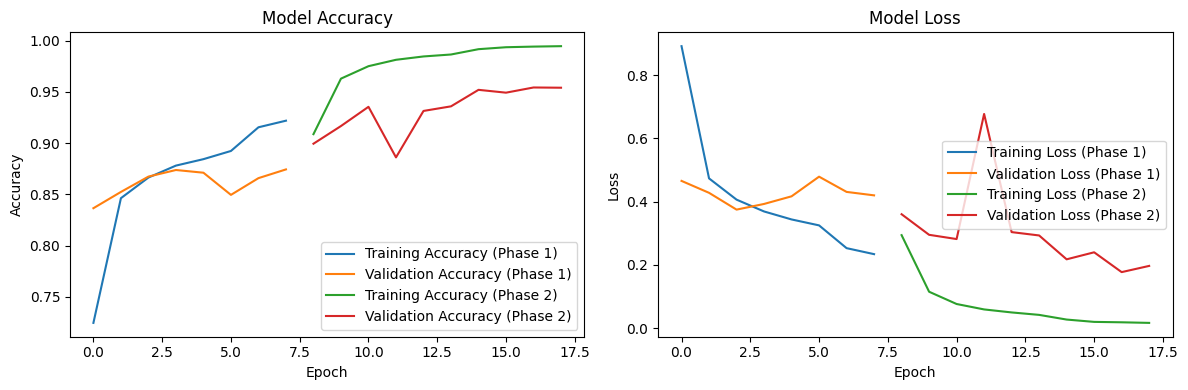


TRAINING COMPLETE!
Final Training Accuracy: 0.9219
Final Validation Accuracy: 0.8744


In [41]:
# ========================================
# PLOT TRAINING HISTORY
# ========================================

plt.figure(figsize=(12, 4))

# Plot accuracy
plt.subplot(1, 2, 1)
plt.plot(history_fine.history['accuracy'], label='Training Accuracy (Phase 1)')
plt.plot(history_fine.history['val_accuracy'], label='Validation Accuracy (Phase 1)')
if history_fine:
    plt.plot(range(len(history.history['accuracy']), 
                   len(history.history['accuracy']) + len(history_fine.history['accuracy'])),
             history_fine.history['accuracy'], label='Training Accuracy (Phase 2)')
    plt.plot(range(len(history.history['accuracy']), 
                   len(history.history['accuracy']) + len(history_fine.history['accuracy'])),
             history_fine.history['val_accuracy'], label='Validation Accuracy (Phase 2)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Model Accuracy')

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss (Phase 1)')
plt.plot(history.history['val_loss'], label='Validation Loss (Phase 1)')
if history_fine:
    plt.plot(range(len(history.history['loss']), 
                   len(history.history['loss']) + len(history_fine.history['loss'])),
             history_fine.history['loss'], label='Training Loss (Phase 2)')
    plt.plot(range(len(history.history['loss']), 
                   len(history.history['loss']) + len(history_fine.history['loss'])),
             history_fine.history['val_loss'], label='Validation Loss (Phase 2)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Model Loss')

plt.tight_layout()
plt.savefig('training_history.png')
plt.show()

print("\n" + "="*50)
print("TRAINING COMPLETE!")
print("="*50)
print(f"Final Training Accuracy: {history.history['accuracy'][-1]:.4f}")
print(f"Final Validation Accuracy: {history.history['val_accuracy'][-1]:.4f}")

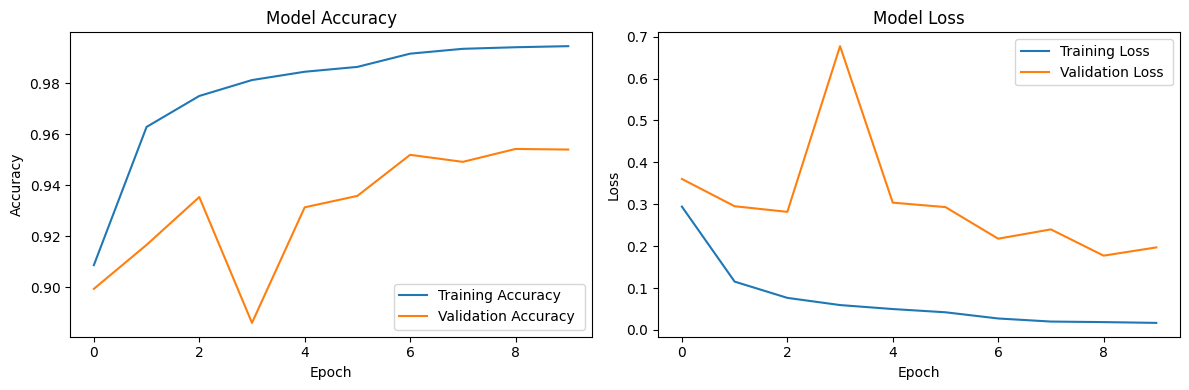


TRAINING COMPLETE!
Final Training Accuracy: 0.9945
Final Validation Accuracy: 0.9540


In [48]:
# ========================================
# PLOT TRAINING HISTORY After Tuning
# ========================================

plt.figure(figsize=(12, 4))

# Plot accuracy
plt.subplot(1, 2, 1)
plt.plot(history_fine.history['accuracy'], label='Training Accuracy ')
plt.plot(history_fine.history['val_accuracy'], label='Validation Accuracy ')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Model Accuracy')


# Plot loss
plt.subplot(1, 2, 2)
plt.plot(history_fine.history['loss'], label='Training Loss ')
plt.plot(history_fine.history['val_loss'], label='Validation Loss ')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Model Loss')

plt.tight_layout()
plt.savefig('training_history.png')
plt.show()

print("\n" + "="*50)
print("TRAINING COMPLETE!")
print("="*50)
print(f"Final Training Accuracy: {history_fine.history['accuracy'][-1]:.4f}")
print(f"Final Validation Accuracy: {history_fine.history['val_accuracy'][-1]:.4f}")


In [44]:
from tensorflow.keras.models import load_model
model = load_model("/kaggle/working/asl_gesture_model_final.h5")


In [46]:
    import numpy as np
    from tensorflow.keras.preprocessing import image
    
    img_path = '/kaggle/input/asl-alphabet/asl_alphabet_test/asl_alphabet_test/A_test.jpg'
    
    
    img = image.load_img(img_path, target_size=(128, 128))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = x / 255.0
    
    pred = model.predict(x)
    predicted_class = np.argmax(pred)
    
    labels = list(train_gen.class_indices.keys())
    predicted_label = labels[predicted_class]
    
    true_label = "A"
    if predicted_label == true_label:
        print(f"Correct! The letter is {predicted_label}")
    else:
        print(f"Incorrect! Predicted: {predicted_label}, True: {true_label}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
✅ Correct! The letter is A
